# EEG PreProcessing for Hyper Alignment Project

Try stuff. 

In [ ]:
%matplotlib inline

import os
import csv
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import mne

# MNE associated & pre-processing code
from mne.preprocessing import ICA
from autoreject import AutoReject

import faster 

# Classification stuff
from sklearn import svm
from sklearn.model_selection import cross_val_score, LeaveOneOut

In [2]:
# ## Functions
# def org_files(files):
#     """Get the preprocessed, EEG data file names (csv format) a specified subject."""

#     eeg = [fi for fi in files if 'events' not in fi]
#     evs = [fi for fi in files if 'events' in fi]

#     # Quick hack to ignore subjs with problematic files
#     if not len(eeg) == len(evs):
#         print('Oh Shit. Something seems to have gone wrong.')
#         return None, None

#     return eeg, evs

def get_files(files, num):
    """Return specified file type from list of files.
    Note: scrappy implementation - returns only first found file that matches pattern. 
    """
    
    for file in files:
        if num in file:
            return file

## Settings


In [3]:
# Settings


## Load Data

Dataset description:

The EEG data used is a database collected and made available by the Child Mind Institute.

It is part of the Multimodal Resource for Studying Information Processing in the Developing Brain (MIPDB) database.

MIPDB Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/

EEG Data Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/eeg.html

In [4]:
# Set data path
dat_path = '/Users/jarrodmhicks/Desktop/'
# ToDo: general stuff to get a list of available subjects

In [5]:
# Set subject to load
sub_num = 'A00054023'
subj_path = os.path.join(dat_path, sub_num, 'EEG', 'raw', 'raw_format')

In [6]:
# Get list of subject files
subj_files = os.listdir(subj_path)

# Restrict to only data files (avoids hidden files, etc)
subj_files = [file for file in subj_files if 'A0' in file]

In [7]:
# Get specific block
#  Note: want to start with contrast change detection: '006', 008', '010'
f_type = ['06', '08', '10']
block_objects = []
for f_num in f_type:
    try:
        cur_eeg_file = get_files(subj_files, f_num)
        block_objects.append(mne.io.read_raw_egi(os.path.join(subj_path, cur_eeg_file), preload=True))
    except:
        pass

if len(block_objects) == 0:
    raise ValueError('There are no valid blocks for this subject.')

Reading EGI header from /Users/jarrodmhicks/Desktop/A00054023/EEG/raw/raw_format/A00054023006.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {102 , 103 , 104 , 105 , 106 , 11  , 14  , 15  , 16  , 17  , 18  , 20  , 21  , 22  , 23  , 24  , 25  , 26  , 27  , 28  , 30  , 31  , 32  , 33  , 34  , 35  , 4   , 50  , 82  , 83  , 84  , 85  , 86  , 90  , 91  , 92  , 93  , 94  , 95  , 96  , 97  } ...
Reading 0 ... 100799  =      0.000 ...   201.598 secs...
Reading EGI header from /Users/jarrodmhicks/Desktop/A00054023/EEG/raw/raw_format/A00054023008.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {102 , 103 , 104 , 105 , 106 , 11  , 14  , 15  , 16  , 17  , 18  , 20  , 21  , 22  , 23  , 24  , 25  , 26  , 27  , 28  , 30  , 31  , 32  , 33  , 34  , 35  , 4   , 50  , 82  , 83  , 84  , 85  , 86  , 90  , 91  , 92  , 93  , 94  , 95  , 9

In [8]:
print(block_objects)

[<RawEGI  |  A00054023006.raw, n_channels x n_times : 176 x 100800 (201.6 sec), ~135.7 MB, data loaded>, <RawEGI  |  A00054023008.raw, n_channels x n_times : 176 x 102377 (204.8 sec), ~137.8 MB, data loaded>, <RawEGI  |  A00054023010.raw, n_channels x n_times : 176 x 102827 (205.7 sec), ~138.4 MB, data loaded>]


In [9]:
# Load subject of data
# raw = mne.io.read_raw_egi(os.path.join(subj_path, cur_eeg_file), preload=True)

In [10]:
# Sanity check consistency
event_mapping = {'12  ': 1, '13  ': 2, '5   ': 3, '8   ': 4, '9   ': 5}
for raw in block_objects:
    if raw.event_id != event_mapping:
        print(raw.event_id)
        raise ValueError("WARNING: event mapping issue.")

In [11]:
# Check event codes present from the file
set(mne.find_events(block_objects[0])[:, 2])

73 events found
Event IDs: [1 2 3 4 5]


{1, 2, 3, 4, 5}

## Set up Data


### Montage

In [ ]:
# ToDo: Solve the E129 mystery
#  Note: this might be easier to load the channel file packaged with the dataset

In [12]:
# Load standard montage
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=block_objects[0].ch_names)

for raw in block_objects:
    raw.set_montage(montage)

    # Hack for 129
    raw.set_channel_types({'E129': 'misc'})

The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.
The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.
The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.


<ipython-input-12-c4ac42dc30ab>:5: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.
  raw.set_montage(montage)
<ipython-input-12-c4ac42dc30ab>:5: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.
  raw.set_montage(montage)
<ipython-input-12-c4ac42dc30ab>:5: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.
  raw.set_montage(montage)


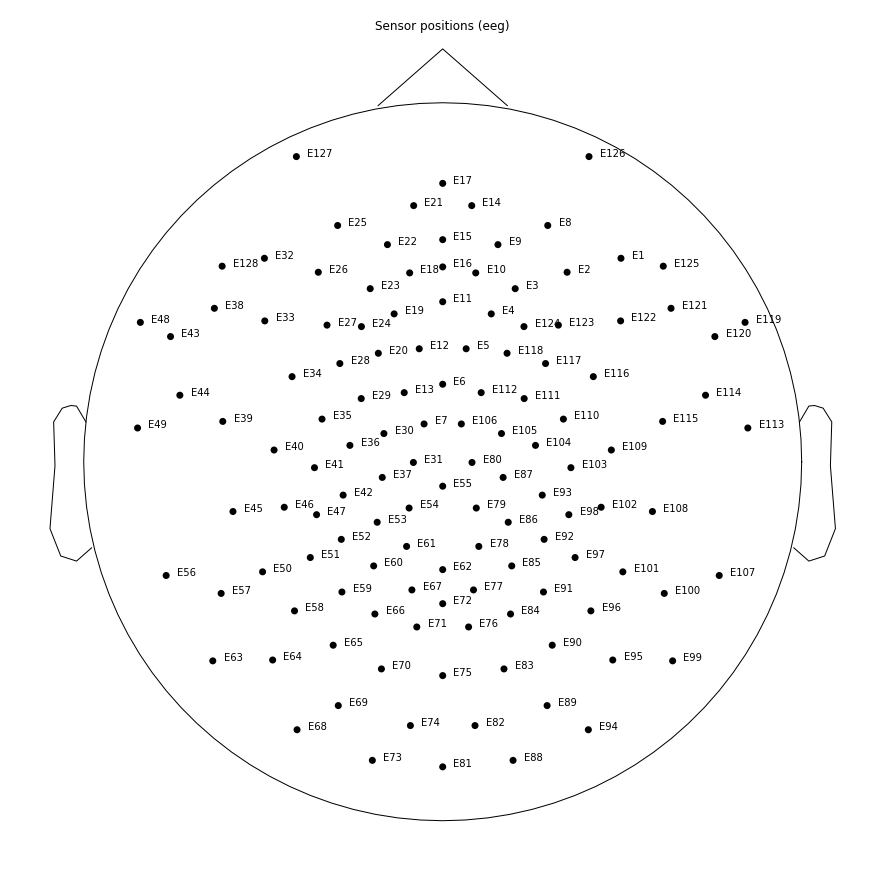

In [13]:
# Check channel locations
fig, ax = plt.subplots(figsize=[12, 12]);
block_objects[0].plot_sensors(show_names=True, axes=ax);

## Sanity Check Data

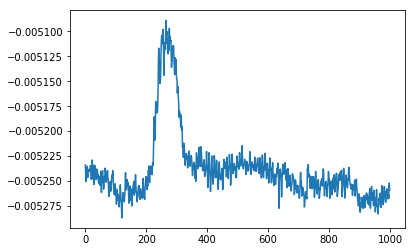

In [14]:
# Print out a small snippet of data
plt.plot(block_objects[0]._data[0, 0:1000])

Effective window size : 4.096 (s)


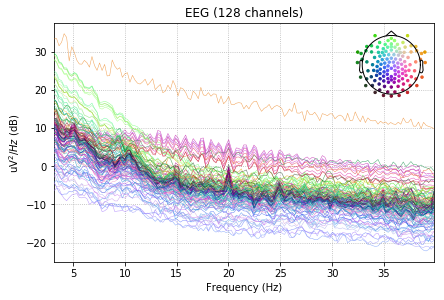

In [15]:
# Check the power spectrum of each channel
block_objects[0].plot_psd(tmin=10, fmin=3, fmax=40);

In [ ]:
#raw.plot_psd_topo();

## Pre-Processing

Run pre-processing on the data. 

In [ ]:
# Note we might need to add something about bad channels here

In [16]:
# Referencing
for raw in block_objects:
    raw.set_eeg_reference(ref_channels='average', projection=True)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


In [17]:
# High pass filter
for raw in block_objects:
    raw.filter(l_freq=0.1, h_freq=15, fir_design='firwin')

Setting up band-pass filter from 0.1 - 15 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 16501 samples (33.002 sec) selected
Setting up band-pass filter from 0.1 - 15 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 16501 samples (33.002 sec) selected
Setting up band-pass filter from 0.1 - 15 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 16501 samples (33.002 sec) selected


### Events & Epoching

Event code descriptions:
- 3 :  5  = start trial
- 4 :  8  = Target ON left
- 5 :  9  = Target ON right
- 1 : 12  = button press left
- 2 : 13  = button press right

In [18]:
# Epoch settings
tmin, tmax = -1, 1

# Event code descriptions
targets = [4, 5]
respons = [1, 2]

In [19]:
# Check how many of each event
# Counter(dat_evs[:, 2])

In [20]:
# Check event code mapping
# raw.event_id

In [21]:
# Check events
# dat_evs = mne.find_events(raw)

In [22]:
# Check event codes
# fig, ax = plt.subplots(figsize=[6, 6])
# # _ = mne.viz.plot_events(dat_evs, raw.info['sfreq'], axes=ax, show=False)
# ax.set_yticklabels(['BPL', 'BPR', 'ST', 'LT', 'RT']);

In [23]:
# Epoch data
epochs_list = [mne.Epochs(raw, mne.find_events(raw), event_id=targets) for raw in block_objects]

73 events found
Event IDs: [1 2 3 4 5]
24 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
74 events found
Event IDs: [1 2 3 4 5]
24 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
74 events found
Event IDs: [1 2 3 4 5]
24 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [40]:
epochs = mne.concatenate_epochs(epochs_list)

Loading data for 24 events and 351 original time points ...
Loading data for 24 events and 351 original time points ...
Loading data for 24 events and 351 original time points ...
72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped


In [41]:
# Sanity check event time series
# epochs.plot();

In [42]:
# Bad channel detection 
bad_channels = faster.faster_bad_channels(epochs)

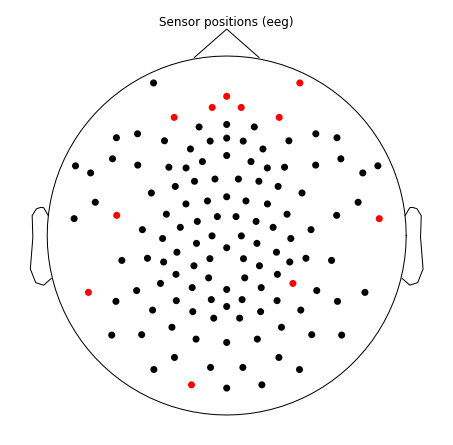

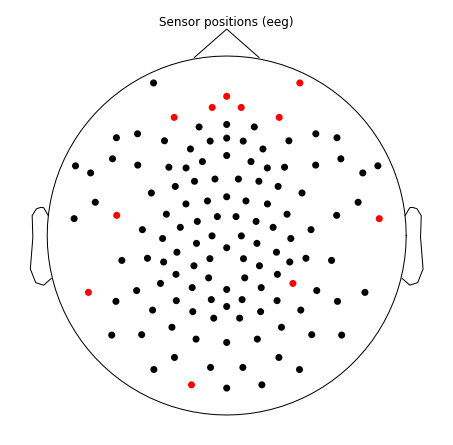

In [72]:
epochs.plot_sensors()

In [43]:
print(bad_channels)

['E113', 'E126', 'E14', 'E17', 'E21', 'E25', 'E39', 'E56', 'E73', 'E8', 'E97']


In [48]:

bad_chis = []
for ch in bad_channels:
    bad_chis.append(epochs.ch_names.index(ch))

In [67]:
bad_chis

[112, 125, 13, 16, 20, 24, 38, 55, 72, 7, 96]

In [56]:
epochs.average().plot?

Object `plot` not found.


In [62]:
evoked = epochs.average()

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-71-375cded0e81b>:1: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  evoked.plot(exclude=[])


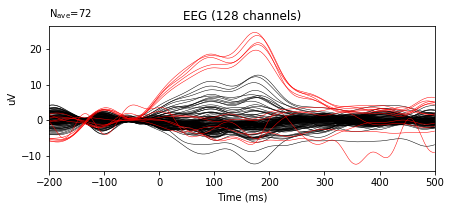

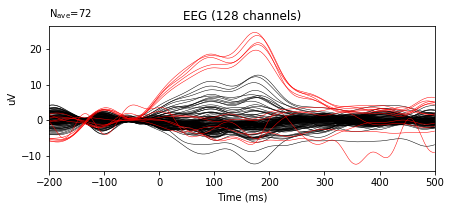

In [71]:
evoked.plot(exclude=[])

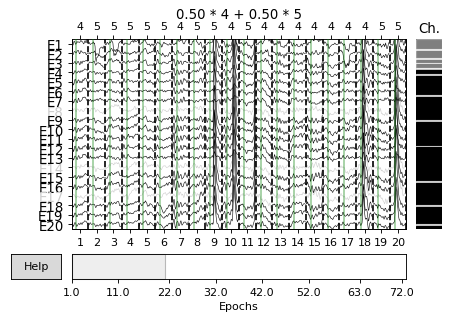

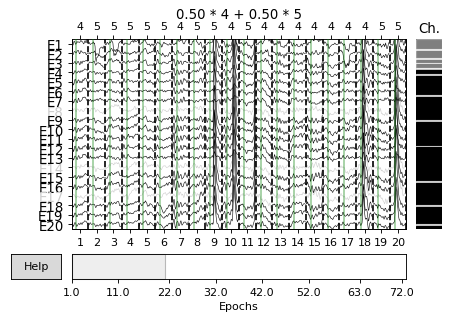

In [51]:
epochs.plot()

In [47]:
epochs.info['bads'] = bad_channels
#epochs.drop_channels(bad_channels)

In [39]:
epochs._data.shape

(72, 165, 351)

### ICA

Note: can run ICA and automatically reject eye from corralation with very frontal channels: E127. E126

In [ ]:
# ICA Settings
method = 'fastica'
n_components = None
random_state = 47
decim = None
reject = {'eeg': 25e-4}

In [ ]:
# Initialize ICA object
ica = ICA(n_components=n_components, method=method, random_state=random_state)

In [ ]:
# Fit ICA
ica.fit(raw, decim=decim, reject=reject)

In [ ]:
# You can now use the ICA solution to find EOG related components
inds, scores = ica.find_bads_eog(raw, ch_name='E126')

In [ ]:
# Plot the ICA components
ica.plot_components()

In [ ]:
# Save out the ICA solution
#ica.save()

### Filtering

In [ ]:
# Filter setting
low_freq = 1
high_freq = 20

In [ ]:
# Filter EEG data
raw.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin')

### AutoReject

Note: only works on epoched trials

In [ ]:
# Initialize autoreject object
#ar = AutoReject()

In [ ]:
# Run AutoReject
#epochs, rej_log = ar.fit_transform(epochs, True)

# Analyses

At this point, the rest becomes specific to the particular analyses that need to be done.

In [ ]:
# Calcualte ERPs
evoked = epochs.average()

In [ ]:
# Plot ERPs
evoked.plot();

In [ ]:
# Check topographies across time
evoked.plot_topomap([-0.1, 0, 0.200, 0.4]);

# Classification

Decode both to the stimulus, and to the response.

In [ ]:
# SVM Classification, on analytic amplitude of alpha data
clf = svm.SVC(kernel='linear')

In [ ]:
#data = ...
#labels = ...

In [ ]:
scores = cross_val_score(clf, data, labels, cv=5)